In [ ]:
#import libraries
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt # Import the relevant module
from matplotlib import pyplot

In [ ]:
def load_fashion_mnsit_dataset():
  
  # example of loading the fashion mnist dataset  
  from matplotlib import pyplot
  from keras.datasets import fashion_mnist

  # load dataset
  (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
  # summarize loaded dataset
  print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
  print('Test: X=%s, y=%s' % (testX.shape, testY.shape))

  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))
  
  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)

  return (trainX, trainY), (testX, testY)



In [ ]:
#Set hyper-parameters for our training of neural networks
LEARNING_RATE = 0.001
EPOCH = 100
VERBOSE = 1

TRAINING_SIZE = 3000
TEST_SIZE = 2000

#No of target models
NUM_TARGET = 1 
#No of shadow models
NUM_SHADOW = 6

#Label value "in" for records present in training data of shadow models 
IN = 1
#Label value "out" for records not present in training data of shadow models 
OUT = 0

In [ ]:
def sample_data(train_data,test_data,num_sets):
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    new_x_train, new_y_train = [], []
    new_x_test, new_y_test = [], []
    for i in range(num_sets):
        x_temp, y_temp = resample(x_train, y_train, n_samples=TRAINING_SIZE, random_state=0)
        new_x_train.append(x_temp)
        new_y_train.append(y_temp)
        x_temp, y_temp = resample(x_test, y_test, n_samples=TEST_SIZE, random_state=0)
        new_x_test.append(x_temp)
        new_y_test.append(y_temp)
    return (new_x_train, new_y_train), (new_x_test, new_y_test)

In [ ]:
def get_attack_dataset(models, train_data, test_data, num_models, data_size):

    # generate dataset for the attack model
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    num_classes = 10
    x_data, y_data = [[] for i in range(num_classes)], [[] for i in range(num_classes)]
    for i in range(num_models):
  
        # IN data
        x_temp, y_temp = resample(x_train[i], y_train[i], n_samples=data_size, random_state=0)

        #print(x_temp)
        #print(y_temp)
        #print(x_temp[0][0])

        for j in range(data_size):
            #print(j)
            y_idx = np.argmax(y_temp[j])
            x_data[y_idx].append(models[i].predict(x_temp[j:j+1])[0])
            #x_data[y_idx].append(models[i].predict(x_temp[j])[0])
            y_data[y_idx].append(IN)

        # OUT data
        x_temp, y_temp = resample(x_test[i], y_test[i], n_samples=data_size, random_state=0)

        #print(x_temp)
        #print(y_temp)

        for j in range(data_size):
            #print(j)
            y_idx = np.argmax(y_temp[j])
            x_data[y_idx].append(models[i].predict(x_temp[j:j+1])[0])
            #x_data[y_idx].append(models[i].predict(x_temp[j])[0])
            y_data[y_idx].append(OUT)

    return x_data, y_data

In [ ]:
def build_fcnn_model_fashion_mnist():
  from keras.models import Sequential
  from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
  model = tf.keras.models.Sequential([ 
  tf.keras.layers.Flatten(input_shape=(28, 28)), 
  tf.keras.layers.Dense(128, activation='relu'),    
  tf.keras.layers.Dense(10, activation='softmax')     
  ])
  model.summary()
  return model

In [ ]:
def get_trained_keras_models(keras_model, train_data, test_data, num_models):
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    models = []
    for i in range(num_models):
        models.append(tensorflow.keras.models.clone_model(keras_model))
        rms = tensorflow.keras.optimizers.RMSprop(lr=LEARNING_RATE, decay=1e-7)
        models[i].compile(loss='binary_crossentropy', optimizer=rms, metrics=['accuracy'])
        models[i].fit(x_train[i], y_train[i], batch_size=32, epochs=EPOCH, verbose=VERBOSE, shuffle=True)
        score = models[i].evaluate(x_test[i], y_test[i], verbose=VERBOSE)
        print('\n', 'Model ', i, ' test accuracy:', score[1])
    return models

In [ ]:
def get_trained_svm_models(train_data, test_data, num_models=1):
    from sklearn import svm
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    models = []
    for i in range(num_models):
        print('Training svm model : ', i)
        models.append(svm.SVC(gamma='scale',kernel='linear',verbose=VERBOSE))
        models[i].fit(x_train[i], y_train[i])
        score = models[i].score(x_test[i],y_test[i])
        print('SVM model ', i, 'score : ',score)
    return models

## Membership Attack when Target Model has 10 Output Classes

In [ ]:
#Train size=3000
#Test size=2000

no_of_shadow_models_10_class=[]
accuracy_10_class_attack=[]

In [ ]:
NUM_SHADOW = 2
membership_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_17 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 0s 1ms/step - loss: 9.5333 - accuracy: 0.5227
Epoch 2/100
94/94 [==============================] - 0s 1ms/step - loss: 1.5659 - accuracy: 0.7346
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 1.0275 - accuracy: 0.7607
Epoch 4/

In [ ]:
accuracy_10_class_attack.append(0.5913)
no_of_shadow_models_10_class.append(2)

In [ ]:
NUM_SHADOW = 3
membership_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 0s 1ms/step - loss: 11.3021 - accuracy: 0.4627
Epoch 2/100
94/94 [==============================] - 0s 1ms/step - loss: 1.5916 - accuracy: 0.7217
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 0.9967 - accuracy: 0.7735
Epoch 4

In [ ]:
accuracy_10_class_attack.append(0.6102)
no_of_shadow_models_10_class.append(3)

In [ ]:
NUM_SHADOW = 4
membership_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 0s 1ms/step - loss: 12.0256 - accuracy: 0.4903
Epoch 2/100
94/94 [==============================] - 0s 1ms/step - loss: 1.7843 - accuracy: 0.7256
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 1.0314 - accuracy: 0.7751
Epoch 4

In [ ]:
accuracy_10_class_attack.append(0.6021)
no_of_shadow_models_10_class.append(4)

In [ ]:
NUM_SHADOW = 5
membership_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 0s 1ms/step - loss: 9.0763 - accuracy: 0.5055
Epoch 2/100
94/94 [==============================] - 0s 1ms/step - loss: 1.9259 - accuracy: 0.7285
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 0.9590 - accuracy: 0.7540
Epoch 4/

In [ ]:
accuracy_10_class_attack.append(0.5913)
no_of_shadow_models_10_class.append(5)

In [ ]:
NUM_SHADOW = 6
membership_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 0s 1ms/step - loss: 13.0695 - accuracy: 0.4866
Epoch 2/100
94/94 [==============================] - 0s 1ms/step - loss: 2.1419 - accuracy: 0.7221
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 1.1374 - accuracy: 0.7742
Epoch 4

In [ ]:
accuracy_10_class_attack.append(0.6370)
no_of_shadow_models_10_class.append(6)

In [ ]:
NUM_SHADOW = 7
membership_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 0s 1ms/step - loss: 9.6029 - accuracy: 0.4534
Epoch 2/100
94/94 [==============================] - 0s 1ms/step - loss: 1.4941 - accuracy: 0.7101
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 0.8784 - accuracy: 0.7709
Epoch 4/

In [ ]:
accuracy_10_class_attack.append(0.6129)
no_of_shadow_models_10_class.append(7)

In [ ]:
NUM_SHADOW = 8
membership_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 0s 1ms/step - loss: 12.3783 - accuracy: 0.4725
Epoch 2/100
94/94 [==============================] - 0s 988us/step - loss: 2.5437 - accuracy: 0.7306
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 1.6891 - accuracy: 0.7815
Epoch

In [ ]:
accuracy_10_class_attack.append(0.6102)
no_of_shadow_models_10_class.append(8)

In [ ]:
NUM_SHADOW = 9
membership_attack()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 0s 1ms/step - loss: 10.3685 - accuracy: 0.4673
Epoch 2/100
94/94 [==============================] - 0s 995us/step - loss: 1.9371 - accuracy: 0.7319
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 1.3095 - accuracy: 0.7745
Epoch

In [ ]:
accuracy_10_class_attack.append(0.6344)
no_of_shadow_models_10_class.append(9)

In [ ]:
accuracy_10_class_attack

[0.5913, 0.6102, 0.6021, 0.5913, 0.637, 0.6129, 0.6102, 0.6344]

In [ ]:
no_of_shadow_models_10_class

[2, 3, 4, 5, 6, 7, 8, 9]

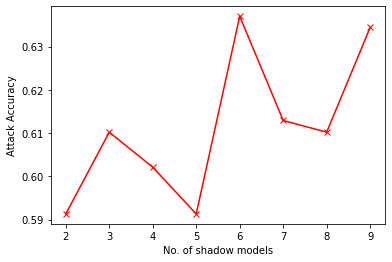

In [ ]:
import matplotlib.pyplot as plt

plt.plot(no_of_shadow_models_10_class, accuracy_10_class_attack, 'r', marker = 'x') 
ax = plt.gca()
plt.xlabel("No. of shadow models")
plt.ylabel("Attack Accuracy")
plt.show()


## Membership Attack when Target Model has k=5 Output Classes

In [ ]:
# Will load dataset with only 5 classes

def load_fashion_mnsit_dataset_specific_classes():

  # example of loading the fashion mnist dataset  
  from matplotlib import pyplot
  from keras.datasets import fashion_mnist

  # load dataset
  (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
     
  # summarize loaded dataset
  #print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
  #print('Test: X=%s, y=%s' % (testX.shape, testY.shape))
    
  # load only class 0,1,2,4
  train_mask = np.isin(trainY, [0, 1, 2, 3, 4]) 
  test_mask = np.isin(testY, [0, 1, 2, 3, 4]) 

  trainX, trainY = trainX[train_mask], trainY[train_mask]
  testX, testY = testX[test_mask], testY[test_mask]  

  # summarize loaded dataset
  #print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
  #print('Test: X=%s, y=%s' % (testX.shape, testY.shape))

  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))
  
  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)

  return (trainX, trainY), (testX, testY)

In [ ]:
# load the pre-shuffled train and test data
(x_train, y_train), (x_test, y_test) = load_fashion_mnsit_dataset_specific_classes()

In [ ]:
x_train.shape

(30000, 28, 28, 1)

In [ ]:
y_train.shape

(30000, 5)

In [ ]:
x_test.shape

(5000, 28, 28, 1)

In [ ]:
y_test.shape

(5000, 5)

In [ ]:
import tensorflow as tf

def build_fcnn_model_fashion_mnist_k_classes():
  model = tf.keras.models.Sequential([ 
  tf.keras.layers.Flatten(input_shape=(28, 28)), 
  tf.keras.layers.Dense(128, activation='relu'),    
  tf.keras.layers.Dense(5, activation='softmax')     
  ])

  model.summary()
  return model


In [ ]:
def membership_attack_k_classes():

  # load the pre-shuffled train and test data
  (x_train, y_train), (x_test, y_test) = load_fashion_mnsit_dataset_specific_classes()

  # split the data for each model
  target_train = (x_train[:TRAINING_SIZE*NUM_TARGET],y_train[:TRAINING_SIZE*NUM_TARGET])
  target_test = (x_test[:TEST_SIZE*NUM_TARGET],y_test[:TEST_SIZE*NUM_TARGET])
  target_train_data, target_test_data = sample_data(target_train, target_test, NUM_TARGET)

  shadow_train = (x_train[TRAINING_SIZE*NUM_TARGET:],y_train[TRAINING_SIZE*NUM_TARGET:])
  shadow_test = (x_test[TEST_SIZE*NUM_TARGET:],y_test[TEST_SIZE*NUM_TARGET:])
  shadow_train_data, shadow_test_data = sample_data(shadow_train, shadow_test, NUM_SHADOW)

  #cnn_model = build_fcnn_model()
  cnn_model = build_fcnn_model_fashion_mnist_k_classes()
  
  # compile the target model
  target_models = get_trained_keras_models(cnn_model, target_train_data, target_test_data, NUM_TARGET)
  # compile the shadow models
  shadow_models = get_trained_keras_models(cnn_model, shadow_train_data, shadow_test_data, NUM_SHADOW)

  # get train data for the attack model
  attack_train = get_attack_dataset_specific_classes(shadow_models, shadow_train_data, shadow_test_data, NUM_SHADOW, TEST_SIZE)
  # get test data for the attack model
  attack_test = get_attack_dataset_specific_classes(target_models, target_train_data, target_test_data, NUM_TARGET, TEST_SIZE)

  # training the attack model
  attack_model = get_trained_svm_models(attack_train, attack_test)


In [ ]:
def get_attack_dataset_specific_classes(models, train_data, test_data, num_models, data_size):
    # generate dataset for the attack model
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    num_classes = 5
    x_data, y_data = [[] for i in range(num_classes)], [[] for i in range(num_classes)]
    for i in range(num_models):
        
        # IN data
        x_temp, y_temp = resample(x_train[i], y_train[i], n_samples=data_size, random_state=0)

        #print(x_temp)
        #print(y_temp)
        #print(x_temp[0][0])

        for j in range(data_size):
            #print(j)
            y_idx = np.argmax(y_temp[j])
            x_data[y_idx].append(models[i].predict(x_temp[j:j+1])[0])
            #x_data[y_idx].append(models[i].predict(x_temp[j])[0])
            y_data[y_idx].append(IN)
        # OUT data
        x_temp, y_temp = resample(x_test[i], y_test[i], n_samples=data_size, random_state=0)

        #print(x_temp)
        #print(y_temp)

        for j in range(data_size):
            #print(j)
            y_idx = np.argmax(y_temp[j])
            x_data[y_idx].append(models[i].predict(x_temp[j:j+1])[0])
            #x_data[y_idx].append(models[i].predict(x_temp[j])[0])
            y_data[y_idx].append(OUT)
    return x_data, y_data



In [ ]:
no_of_shadow_models_5_class=[]
accuracy_5_class_attack=[]

In [ ]:
NUM_SHADOW = 2
membership_attack_k_classes()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               100480    
                                                                 
 dense_9 (Dense)             (None, 5)                 645       
                                                                 
Total params: 101,125
Trainable params: 101,125
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


94/94 [==============================] - 1s 3ms/step - loss: 6.9921 - accuracy: 0.7180
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 2.5338 - accuracy: 0.8030
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 1.7356 - accuracy: 0.8373
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 1.1554 - accuracy: 0.8427
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.7686 - accuracy: 0.8537
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.4189 - accuracy: 0.8227
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2721 - accuracy: 0.8127
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2410 - accuracy: 0.8393
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2419 - accuracy: 0.8387
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1739 - accuracy: 0.8633
Epoch 11/100
94/94 [=

In [ ]:
no_of_shadow_models_5_class.append(2)
accuracy_5_class_attack.append(0.5399)

In [ ]:
NUM_SHADOW = 3
membership_attack_k_classes()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               100480    
                                                                 
 dense_11 (Dense)            (None, 5)                 645       
                                                                 
Total params: 101,125
Trainable params: 101,125
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


94/94 [==============================] - 1s 3ms/step - loss: 10.9389 - accuracy: 0.6943
Epoch 2/100
94/94 [==============================] - 0s 2ms/step - loss: 3.9259 - accuracy: 0.8160
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 1.8968 - accuracy: 0.8423
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 1.1829 - accuracy: 0.8573
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 1.0103 - accuracy: 0.8673
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.7232 - accuracy: 0.8760
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.3664 - accuracy: 0.8663
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.3214 - accuracy: 0.8680
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2457 - accuracy: 0.8860
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2625 - accuracy: 0.8850
Epoch 11/100
94/94 [

In [ ]:
no_of_shadow_models_5_class.append(3)
accuracy_5_class_attack.append(0.5387)

In [ ]:
NUM_SHADOW = 4
membership_attack_k_classes()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               100480    
                                                                 
 dense_13 (Dense)            (None, 5)                 645       
                                                                 
Total params: 101,125
Trainable params: 101,125
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


94/94 [==============================] - 1s 3ms/step - loss: 9.2549 - accuracy: 0.7193
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 2.7486 - accuracy: 0.8163
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 1.6685 - accuracy: 0.8417
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 0.9231 - accuracy: 0.8550
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.6151 - accuracy: 0.8657
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.3839 - accuracy: 0.8523
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2700 - accuracy: 0.8680
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2084 - accuracy: 0.8793
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1737 - accuracy: 0.8933
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1497 - accuracy: 0.8923
Epoch 11/100
94/94 [=

In [ ]:
no_of_shadow_models_5_class.append(4)
accuracy_5_class_attack.append(0.5160)

In [ ]:
NUM_SHADOW = 5
membership_attack_k_classes()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 5)                 645       
                                                                 
Total params: 101,125
Trainable params: 101,125
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


94/94 [==============================] - 1s 3ms/step - loss: 8.6539 - accuracy: 0.6960
Epoch 2/100
94/94 [==============================] - 0s 4ms/step - loss: 2.3916 - accuracy: 0.7943
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 1.0745 - accuracy: 0.8273
Epoch 4/100
94/94 [==============================] - 0s 4ms/step - loss: 0.5498 - accuracy: 0.8457
Epoch 5/100
94/94 [==============================] - 0s 4ms/step - loss: 0.2959 - accuracy: 0.8363
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2456 - accuracy: 0.8610
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1873 - accuracy: 0.8687
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1674 - accuracy: 0.8867
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1648 - accuracy: 0.8857
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1457 - accuracy: 0.8903
Epoch 11/100
94/94 [=

In [ ]:
no_of_shadow_models_5_class.append(5)
accuracy_5_class_attack.append(0.5506)

In [ ]:
NUM_SHADOW = 6
membership_attack_k_classes()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 101,125
Trainable params: 101,125
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


94/94 [==============================] - 1s 3ms/step - loss: 8.7178 - accuracy: 0.7083
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 2.9310 - accuracy: 0.8057
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 1.7203 - accuracy: 0.8487
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 1.1446 - accuracy: 0.8633
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.7646 - accuracy: 0.8727
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.3487 - accuracy: 0.8610
Epoch 7/100
94/94 [==============================] - 0s 4ms/step - loss: 0.2616 - accuracy: 0.8810
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2059 - accuracy: 0.8833
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1833 - accuracy: 0.8933
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1548 - accuracy: 0.9000
Epoch 11/100
94/94 [=

In [ ]:
no_of_shadow_models_5_class.append(6)
accuracy_5_class_attack.append(0.5411)

In [ ]:
NUM_SHADOW = 7
membership_attack_k_classes()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               100480    
                                                                 
 dense_15 (Dense)            (None, 5)                 645       
                                                                 
Total params: 101,125
Trainable params: 101,125
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


94/94 [==============================] - 1s 3ms/step - loss: 11.7099 - accuracy: 0.7050
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 3.2584 - accuracy: 0.8133
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 1.4253 - accuracy: 0.8443
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 0.6710 - accuracy: 0.8503
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.4272 - accuracy: 0.8507
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2709 - accuracy: 0.8613
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1972 - accuracy: 0.8777
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1778 - accuracy: 0.8833
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1937 - accuracy: 0.8840
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1881 - accuracy: 0.8860
Epoch 11/100
94/94 [

In [ ]:
no_of_shadow_models_5_class.append(7)
accuracy_5_class_attack.append(0.5482)

In [ ]:
NUM_SHADOW = 8
membership_attack_k_classes()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               100480    
                                                                 
 dense_17 (Dense)            (None, 5)                 645       
                                                                 
Total params: 101,125
Trainable params: 101,125
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


94/94 [==============================] - 1s 3ms/step - loss: 7.8798 - accuracy: 0.7047
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 1.8301 - accuracy: 0.8090
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 1.0971 - accuracy: 0.8217
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 0.3975 - accuracy: 0.8380
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.3581 - accuracy: 0.8437
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2321 - accuracy: 0.8630
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1992 - accuracy: 0.8753
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2049 - accuracy: 0.8787
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1718 - accuracy: 0.8757
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1668 - accuracy: 0.8837
Epoch 11/100
94/94 [=

In [ ]:
no_of_shadow_models_5_class.append(8)
accuracy_5_class_attack.append(0.5435)

In [ ]:
NUM_SHADOW = 9
membership_attack_k_classes()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               100480    
                                                                 
 dense_19 (Dense)            (None, 5)                 645       
                                                                 
Total params: 101,125
Trainable params: 101,125
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


94/94 [==============================] - 1s 3ms/step - loss: 8.4809 - accuracy: 0.7203
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 2.1646 - accuracy: 0.8283
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 1.3956 - accuracy: 0.8390
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 0.8948 - accuracy: 0.8563
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.6732 - accuracy: 0.8723
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.5364 - accuracy: 0.8567
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.2350 - accuracy: 0.8470
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1890 - accuracy: 0.8577
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1775 - accuracy: 0.8733
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.1756 - accuracy: 0.8760
Epoch 11/100
94/94 [=

In [ ]:
no_of_shadow_models_5_class.append(9)
accuracy_5_class_attack.append(0.5423)

In [ ]:
no_of_shadow_models_5_class

[2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
accuracy_5_class_attack

[0.5399, 0.5387, 0.516, 0.5506, 0.5411, 0.5482, 0.5435, 0.5423]

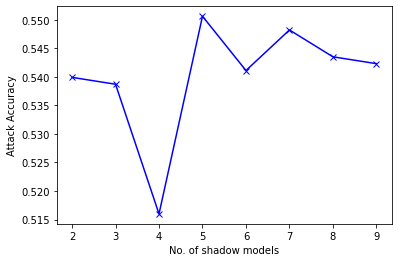

In [ ]:
import matplotlib.pyplot as plt # Impot the relevant module

plt.plot(no_of_shadow_models_5_class, accuracy_5_class_attack, 'b', marker = 'x') 
ax = plt.gca()
plt.xlabel("No. of shadow models")
plt.ylabel("Attack Accuracy")
plt.show()


Comparision of Accuracy with Target Model of 10 output classes versus Target Model of 5 Output Classes:

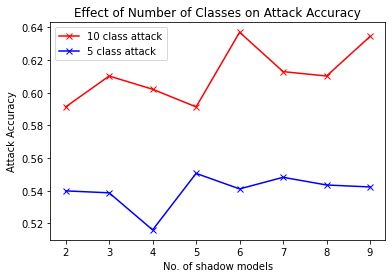

In [ ]:
plt.plot(no_of_shadow_models_10_class, accuracy_10_class_attack, 'r', marker = 'x', label = "10 class attack") 
plt.plot(no_of_shadow_models_5_class, accuracy_5_class_attack, 'b', marker = 'x', label = "5 class attack") 
ax = plt.gca()
plt.xlabel("No. of shadow models")
plt.ylabel("Attack Accuracy")
plt.title('Effect of Number of Classes on Attack Accuracy')
# show a legend on the plot
plt.legend()
plt.show()
